In [1]:
import time, networkx as nx
import requests, matplotlib.pyplot as plt, pandas as pd
from geopy.distance import great_circle, vincenty

%matplotlib inline

In [2]:
# San Francisco
north = 37.81
south = 37.76
east = -122.40
west = -122.45

## Define functions for downloading and processing the OSM data

In [3]:
def osm_download(north, south, east, west):
    start_time = time.time()
    url = 'http://www.overpass-api.de/api/interpreter'
    filters='"highway"!~"motor"' # network type is walking, so exclude things like freeways
    data = '[out:json];(  way  ["highway"]  [{}]  ({},{},{},{});  >;);out;'
    params = {'data' : data.format(filters, south, west, north, east)} #box as south,west,north,east
    response = requests.get(url, params=params)
    print('downloaded data in {:,.2f} seconds from {}'.format(time.time()-start_time, response.url))
    return response.json()

In [4]:
# convert an OSM node element into the format for a networkx node
def get_node(element):
    node = {}
    node['lat'] = element['lat']
    node['lon'] = element['lon']
    if 'tags' in element:
        node['highway'] = element['tags']['highway'] if 'highway' in element['tags'] else None
    return node

In [5]:
# convert an OSM way element into the format for a networkx graph path
def get_path(element):
    path = {}
    path['nodes'] = element['nodes']
    if 'tags' in element:
        path['name'] = element['tags']['name'] if 'name' in element['tags'] else None
        path['city'] = element['tags']['addr:city'] if 'addr:city' in element['tags'] else None
        path['highway'] = element['tags']['highway'] if 'highway' in element['tags'] else None
        path['maxspeed'] = element['tags']['maxspeed'] if 'maxspeed' in element['tags'] else None
    return path

## Download and process the data

In [6]:
# get all nodes and ways by passing in bounding box
osm_data = osm_download(north, south, east, west)

downloaded data in 4.27 seconds from http://www.overpass-api.de/api/interpreter?data=%5Bout%3Ajson%5D%3B%28++way++%5B%22highway%22%5D++%5B%22highway%22%21~%22motor%22%5D++%2837.76%2C-122.45%2C37.81%2C-122.4%29%3B++%3E%3B%29%3Bout%3B


In [7]:
nodes = {}
paths = {}
for element in osm_data['elements']:
    if element['type'] == 'node':
        key = element['id']
        nodes[key] = get_node(element)
    elif element['type'] == 'way': #osm calls network paths 'ways'
        key = element['id']
        paths[key] = get_path(element)

In [8]:
len(osm_data['elements'])

18696

In [9]:
len(nodes)

14425

In [10]:
len(paths)

4271

## Create the graph

In [11]:
G = nx.Graph()

In [12]:
# add each node to the graph
for node_id, node in nodes.items():
    hwy = node['highway'] if 'highway' in node else None
    G.add_node(node_id, osm_id=node_id, lat=node['lat'], lon=node['lon'], highway=hwy)

In [13]:
# add each path to the graph
for path_id, path in paths.items():
    G.add_path(path['nodes'], osm_id=path_id, name=path['name'], city=path['city'], 
               highway=path['highway'], maxspeed=path['maxspeed'])

In [14]:
# if the graph is not connected, get the largest connected subgraph
if not nx.is_connected(G):
    G = max(nx.connected_component_subgraphs(G), key=len)

In [15]:
# add length (great circle distance between vertices) attribute to each edge to use as weight
for u, v in G.edges():
    u_point = (G.node[u]['lat'], G.node[u]['lon'])
    v_point = (G.node[v]['lat'], G.node[v]['lon'])
    edge_length = great_circle(u_point, v_point).m #geopy points are (lat, lon)
    G[u][v]['length'] = edge_length

In [16]:
# change the node labels from osm_ids to the standard sequential integers
G = nx.convert_node_labels_to_integers(G)

In [17]:
len(G.nodes())

14178

In [18]:
len(G.edges())

17033

## Truncate the graph to nodes within 500m of centermost node

In [19]:
central_point = ((north+south)/2, (east+west)/2)
central_point

(37.785, -122.42500000000001)

In [20]:
# return the network node nearest to the specified point. geopy points are (lat, lon)
def get_nearest_node(G, point):
    nodes = G.nodes(data=True)
    nearest_node = min(nodes, key=lambda node: great_circle((node[1]['lat'], node[1]['lon']), point).m)
    return nearest_node[0] 

centermost_node = get_nearest_node(G, central_point)
centermost_node

9064

In [21]:
# remove everything greater than some distance from a specified node in graph
def truncate_graph(G, source_node, max_distance=1000, weight='length'):
    distances = nx.shortest_path_length(G, source=source_node, weight=weight)
    distant_nodes = {k: v for k, v in distances.items() if v > max_distance}
    G.remove_nodes_from(distant_nodes.keys())
    
truncate_graph(G, centermost_node, max_distance=500)
len(G.nodes())

243

## Plot the network

In [22]:
fig_width = 8
bbox_aspect_ratio = (north-south)/(east-west)

In [23]:
lons = [float(node['lon']) for node in G.node.values()]
lats = [float(node['lat']) for node in G.node.values()]

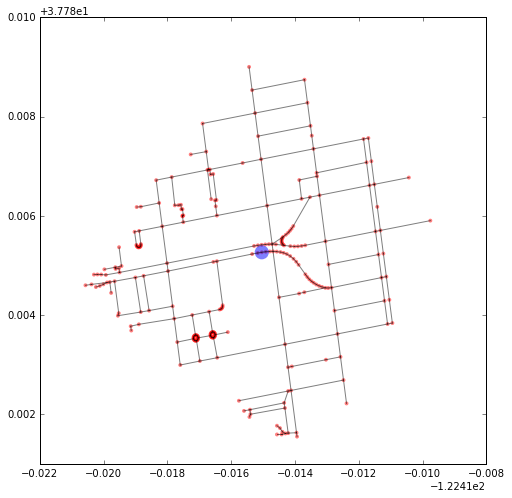

In [24]:
fig, ax = plt.subplots(figsize=(fig_width, fig_width * bbox_aspect_ratio))
for u, v, edge_details in G.edges(data=True):
    x = (G.node[u]['lon'], G.node[v]['lon'])
    y = (G.node[u]['lat'], G.node[v]['lat'])
    ax.plot(x, y, color='k', linewidth=1, alpha=0.5)

ax.scatter(lons, lats, s=15, c='r', alpha=0.5, edgecolor='none')

ax.scatter(G.node[centermost_node]['lon'], 
           G.node[centermost_node]['lat'], 
           s=200, c='b', alpha=0.5, edgecolor='none')

#ax.set_ylim((south, north))
#ax.set_xlim((west, east))
fig.savefig('images/net.png', dpi=100)
plt.show()